In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
path_eth_shp = 'Data/ETH-GADM-Adm-Boundaries/gadm36_ETH_1.shp'
path_fatalities_shp = 'Data/fatalities_per_adm2/fatalities_per_adm2.shp'
path_poverty_pop_data = 'Data/ETH-District-data/Ethiopia_district-data.csv'

In [3]:
# map poverty --------

# load ETH Adm 1 shapefile
eth = gpd.read_file(path_eth_shp)

# clean Adm 1 level MPI and Population data on Ethiopia
poverty_pop_data = pd.read_csv(path_poverty_pop_data, header=0, skiprows=1)
poverty_pop_data = poverty_pop_data[['#date','#adm1+name', 'Unnamed: 3', 'Unnamed: 4']]
poverty_pop_data = poverty_pop_data.rename(index=str, columns={'#date': 'Date',
                                                               'Unnamed: 3': 'MPI',
                                                               'Unnamed: 4': 'Population',
                                                               '#adm1+name': 'Adm1'})

poverty_pop_data["Date"] = pd.to_datetime(poverty_pop_data["Date"])
poverty_pop_data = poverty_pop_data[(poverty_pop_data['Date'] > '2020-10-15 00:00:00')]
poverty_pop_data = poverty_pop_data[['Adm1', 'MPI', 'Population']]
poverty_pop_data['MPI'] = poverty_pop_data['MPI'].astype(float)
poverty_pop_data['Population'] = poverty_pop_data['Population'].astype(int)

poverty_pop_data = poverty_pop_data.replace(to_replace =["SNNPR", 'Addis Ababa', 'Harari', 'Benshangul Gumuz', 'Gambela'],
           value =["Southern Nations, Nationalities and Peoples", 'Addis Abeba', 'Harari People',
                  'Benshangul-Gumaz', 'Gambela Peoples'])

# join Adm 1 shapefile and cleaned Adm 1-level data
poverty = eth.set_index('NAME_1').join(poverty_pop_data.set_index('Adm1')) 

# map conflict --------

# subset population out of adm 1 level data 
pop_data = poverty_pop_data[['Adm1','Population']]

# load shapefile of number of fatalities per Adm 1 (per ACLED, generated using spatial join function in QGIS)
fatalities = gpd.read_file(path_fatalities_shp)

# merge ACLED fatalities and ETH Adm 1 population data 
conflict = fatalities.set_index('NAME_1').join(pop_data.set_index('Adm1'))
conflict.index.name = 'NAME_1'
conflict.reset_index(inplace=True)

# calculate fatalities per 100,000 people per Adm 1
conflict['fatalities_100k'] = ( conflict['fatalities']/conflict['Population'] ) * 100000


Text(0.5, 1, 'ETH Conflict (Num of fatalities per 100,000)')

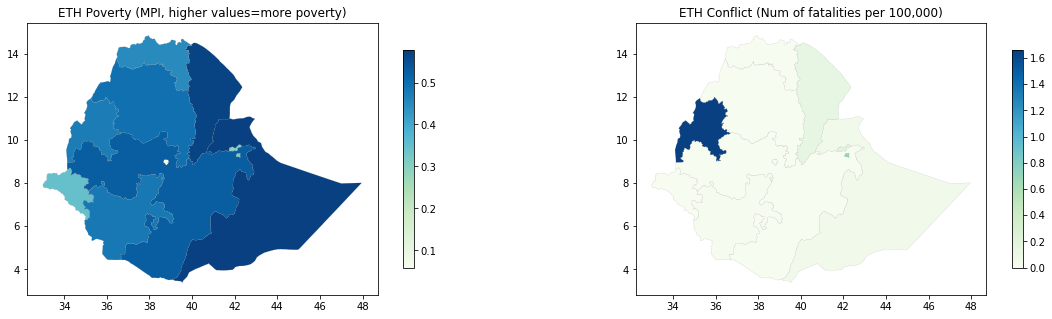

In [4]:
# plot all three side by side: poverty, conflict, and climate

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 5))

cmap = 'GnBu'

poverty.plot(column='MPI', cmap=cmap, ax=ax0, edgecolor='.5', linewidth=.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(poverty['MPI']),
                                                         vmax=max(poverty['MPI'])))
cbar = fig.colorbar(sm, ax=ax0, shrink=.8)
ax0.set_title('ETH Poverty (MPI, higher values=more poverty)')

conflict.plot(column='fatalities_100k', cmap=cmap, ax=ax1, edgecolor='.5', linewidth=.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(conflict['fatalities_100k']),
                                                         vmax=max(conflict['fatalities_100k'])))
cbar = fig.colorbar(sm, ax=ax1, shrink=.8)
ax1.set_title('ETH Conflict (Num of fatalities per 100,000)')
